# Overview

In this notebook, we evaluate the proposed A-ADMM and OR-A-ADMM schemes on the standard ℓ₁-regularized least-squares (LASSO) problem.  


In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

### Helper Functions

In [ ]:
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def A_ADMM_Lasso(A, b, L, m_strong, algo, tau, max_iters, tol, x_star):
    m, n = A.shape
    x = np.zeros((n, max_iters))
    z = np.zeros((n, max_iters))
    u = np.zeros((n, max_iters))
    eigenvalues = np.linalg.eigvalsh(A.T @ A)
    L = np.max(eigenvalues)  # Lipschitz constant
    m_strong = np.min(eigenvalues)  # Strong convexity parameter
    kappa = L/m_strong # condition number

    if algo=='ADMM':
        v1 = 1 
        v2 = 0
        alpha = 1

    elif algo=='OR-ADMM':
        v1 = 1 
        v2 = 0
        alpha = 1.45

    elif algo=='A-ADMM (NM)':
        v1 = 1/L 
        v2 = (np.sqrt(kappa)-1)/(np.sqrt(kappa)+1) 
        alpha = 1


    elif algo=='A-ADMM (GS)':
        gamma = 1-(1/np.sqrt(kappa))
        v1 = (1+gamma)/(L)
        v2 = np.sqrt(np.sqrt((kappa + 0.081796) / (kappa + 49.908))) - 0.20283
        alpha = 1

    elif algo=='OR-A-ADMM (GS)':
        gamma = 1-(1/np.sqrt(kappa))
        v1 = (1+gamma)/(L)
        v2 = (((0.66082 / (kappa + 11.973)) - (-1.5338e-05)) * kappa) - (-0.058909)
        alpha = 1.45

    elif algo=='A-ADMM (TM, λ-damped)':
        gamma = 1-(1/np.sqrt(kappa))
        v1 = (1+gamma)/L 
        v2 = 1*(gamma**2)/(2-gamma)
        alpha = 1
        damp = 0.1

    elif algo=='A-ADMM (TM)':
        gamma = 1-(1/np.sqrt(kappa))
        v1 = (1+gamma)/L 
        v2 = 1*(gamma**2)/(2-gamma)
        alpha = 1
        damp = 0.1

    else:
        raise ValueError(f"Algorithm configuration not known: '{algo}'")


    AtA = A.T @ A
    inv_matrix = np.linalg.inv(v1*AtA + np.eye(n))
    Atb_T = A.T @ b

    init_error = np.linalg.norm(x[:, 0] - x_star)

    residuals = np.zeros(max_iters)
    
    for k in range(max_iters - 1):
        x[:, k + 1] = inv_matrix @ (-(1 + v2) * z[:, k] + v2 * z[:, k - 1] -(1 + v2) * u[:, k] + v2 * u[:, k - 1] + v1*Atb_T) if k > 0 else np.zeros(n)
        z[:, k + 1] = soft_thresholding(- alpha*x[:, k + 1]
                                        -(alpha-1)*(1+v2)* z[:, k] + (alpha-1)*v2*z[:, k - 1]
                                         -(1 + v2) * u[:, k] + v2 * u[:, k - 1], tau*v1)
        
        if algo == 'A-ADMM (TM, λ-damped)':
            u[:, k + 1] = (alpha*x[:, k + 1] +(alpha-1)*(1+v2)* z[:, k] - (alpha-1)*v2*z[:, k - 1] + z[:, k + 1]
                            + (1 + v2 + 1) * u[:, k] - v2 * u[:, k - 1])*damp
            
        else:
            u[:, k + 1] = alpha*x[:, k + 1] +(alpha-1)*(1+v2)* z[:, k] - (alpha-1)*v2*z[:, k - 1] + z[:, k + 1] + (1 + v2) * u[:, k] - v2 * u[:, k - 1]

        residuals[k] = np.linalg.norm(x[:, k + 1] - x_star, ord=2) / init_error

        if residuals[k] < tol:
            break
    
    return residuals[:k+1]

def FISTA_Lasso(A, b, L, m_strong, tau, max_iters, tol, x_star):
    """
    FISTA for strongly convex LASSO using constant Nesterov momentum.
    """
    m, n = A.shape
    x = np.zeros(n)  # Solution
    z = np.zeros(n)  # Momentum iterate
    residuals = []  # Track residuals
    
    # Compute strong convexity parameters
    eigenvalues = np.linalg.eigvalsh(A.T @ A)
    L = np.max(eigenvalues)  # Lipschitz constant
    m_strong = np.min(eigenvalues)  # Strong convexity parameter
    kappa = L / m_strong  # Condition number
    v1 = 1 / L
    v2 = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)  # Constant Nesterov momentum

    # demoninator for residuals
    init_error = np.linalg.norm(x - x_star)

    for k in range(max_iters):

        # Compute residual
        residual = np.linalg.norm(x - x_star, ord=2) / init_error
        residuals.append(residual)

        x_old = x.copy()

        # Gradient update and soft-thresholding
        gradient = A.T @ (A @ z - b)
        x = soft_thresholding(z - v1 * gradient, tau*v1)

        # Nesterov momentum update
        z = x + v2 * (x - x_old)
        
        # Convergence check
        if residual < tol:
            break

    return x, residuals



### Problem setting

In [ ]:
np.random.seed(5) 
A = np.random.randn(250, 100) 
A /= np.linalg.norm(A, axis=0) 
w0 = np.random.randn(100) 
nonzero_indices = np.random.choice(100, 50, replace=False) 
w0[nonzero_indices] = np.random.randn(50) 
epsilon = np.random.normal(0, np.sqrt(1e-3), size=250) 

b = A @ w0 + epsilon 
eigenvalues = np.linalg.eigvalsh(A.T @ A) 
L = np.max(eigenvalues) 
m_strong = np.min(eigenvalues)

tau = 0.01

Compute solution with ``cvxpy``

In [ ]:
x = cvx.Variable(100)

# Define LASSO objective
objective = cvx.Minimize(1/2*cvx.norm(A @ x - b)**2 + tau * cvx.norm1(x))

# Define and solve problem
prob = cvx.Problem(objective)
prob.solve()

x_star = x.value

## Fig.5

C:\Users\asc\AppData\Local\Temp\ipykernel_9108\286924469.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, borderaxespad=0.)


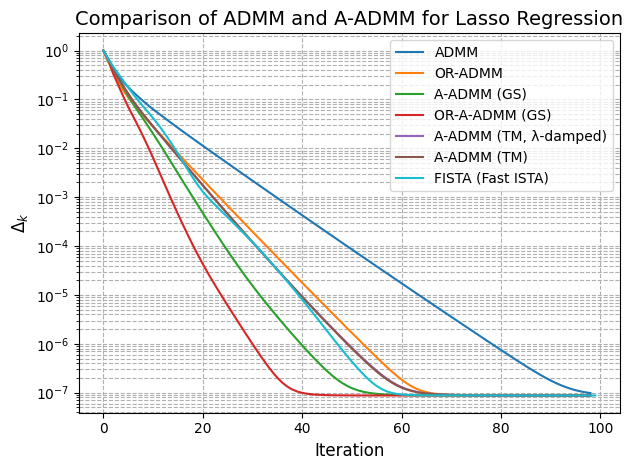

In [ ]:
max_iter = 100
tol=1e-12

algos = ['ADMM', 'OR-ADMM', 'A-ADMM (GS)', 'OR-A-ADMM (GS)', 'A-ADMM (TM, λ-damped)', 'A-ADMM (TM)']

residuals = {
    "alg": np.zeros(len(algos))
}

for algo in algos:
    residuals[algo] = A_ADMM_Lasso(A, b, L, m_strong, algo, tau, max_iter, tol, x_star)
x_fista, residuals_fista = FISTA_Lasso(A, b, L, m_strong, tau, max_iter, tol, x_star)


# Lasso Regression Figure (Fig. 4.)

plt.yscale("log")
plt.xlabel(r"Iteration", fontsize=12)
plt.ylabel(r"Residual / Theoretical Decay", fontsize=12)
plt.ylabel(r"$\Delta_k$", fontsize=12)
plt.grid(True, which="both", linestyle="--")
plt.title(r'Comparison of ADMM and A-ADMM for Lasso Regression', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, borderaxespad=0.)
for algo in algos:
    y = residuals[algo] 
    plt.plot(
        y,
        label=f"{algo}"
    )
    plt.legend()
plt.plot(residuals_fista, label="FISTA (Fast ISTA)", color="C9")
plt.legend()
plt.tight_layout()
plt.show()
